In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def calc_iqm(data):
    sorted_data = np.sort(data)

    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    interquartile_data = sorted_data[(sorted_data >= q1) & (sorted_data <= q3)]
    
    iqm = np.mean(interquartile_data)
    return iqm

In [11]:
def confidence_intervals(data, n_sample, parameter, iterasi=1000, alpha=0.05, stratified=False):
    stats = np.array([])

    for _ in range(iterasi):
        if not stratified:
            sample = data[parameter].sample(n_sample, replace=True)
        else:
            sample = data.groupby('level', group_keys=False).apply(lambda x: x[parameter].sample(n=5, replace=True), include_groups=False).reset_index(drop=True)
        # stat = calc_iqm(sample)
        # stat = np.mean(sample)
        stat = np.median(sample)
        stats = np.append(stats, stat)

    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    
    return stats, lower_bound, upper_bound, np.mean(stats), np.std(stats)

In [4]:
def validate_95_percent_ci(data, lower_bound, upper_bound):
    count_in_range = np.sum((data >= lower_bound) & (data <= upper_bound))
    proportion_in_range = count_in_range / len(data)
    return proportion_in_range

In [5]:
level = []
for i in range(10):
    df = pd.read_csv(f"./UNREAL-eval/uncertainty/csv/{i+1}.csv")
    df["level"] = 10 + i
    level.append(df)
    
level = pd.concat(level, ignore_index=True)
level = level.drop('rewards', axis=1)
level.head()

,lines,score,block_placed,episode_time,episode_length,level
0,0,0,18,10.390690,275,10
1,0,10,19,10.692553,287,10
2,0,24,14,8.715807,227,10
3,0,8,12,6.533472,173,10
4,0,12,12,6.423656,173,10


In [14]:
# Normlized Score
level['normalized_block_placed'] = level.groupby('level')['block_placed'].transform(lambda x: (x - x.min() )/ (x.max() - x.min()))
level['normalized_episode_time'] = level.groupby('level')['episode_time'].transform(lambda x: (x - x.min() )/ (x.max() - x.min()))
level['normalized_episode_length'] = level.groupby('level')['episode_length'].transform(lambda x: (x - x.min() )/ (x.max() - x.min()))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(y='level', x='normalized_episode_time', data=level, ax=axes[0], orient="h")
axes[0].set_title('Normalized Time Survived per Level')
axes[0].set_xlabel('Normalized Time Survived')
axes[0].set_ylabel('Level')

sns.boxplot(y='level', x='normalized_episode_length', data=level, ax=axes[1], orient="h")
axes[1].set_title('Normalized Panjang Episode per Level')
axes[1].set_xlabel('Normalized Episode Length')
axes[1].set_ylabel('Level')


# Menambahkan jarak antar subplots
plt.tight_layout()
plt.show()

Percentage: 98.4%
Percentage: 98.6%
Percentage: 99.5%
Percentage: 99.6%
Percentage: 100.0%
Percentage: 100.0%
Percentage: 100.0%
Percentage: 99.6%
Percentage: 98.5%
Percentage: 97.7%


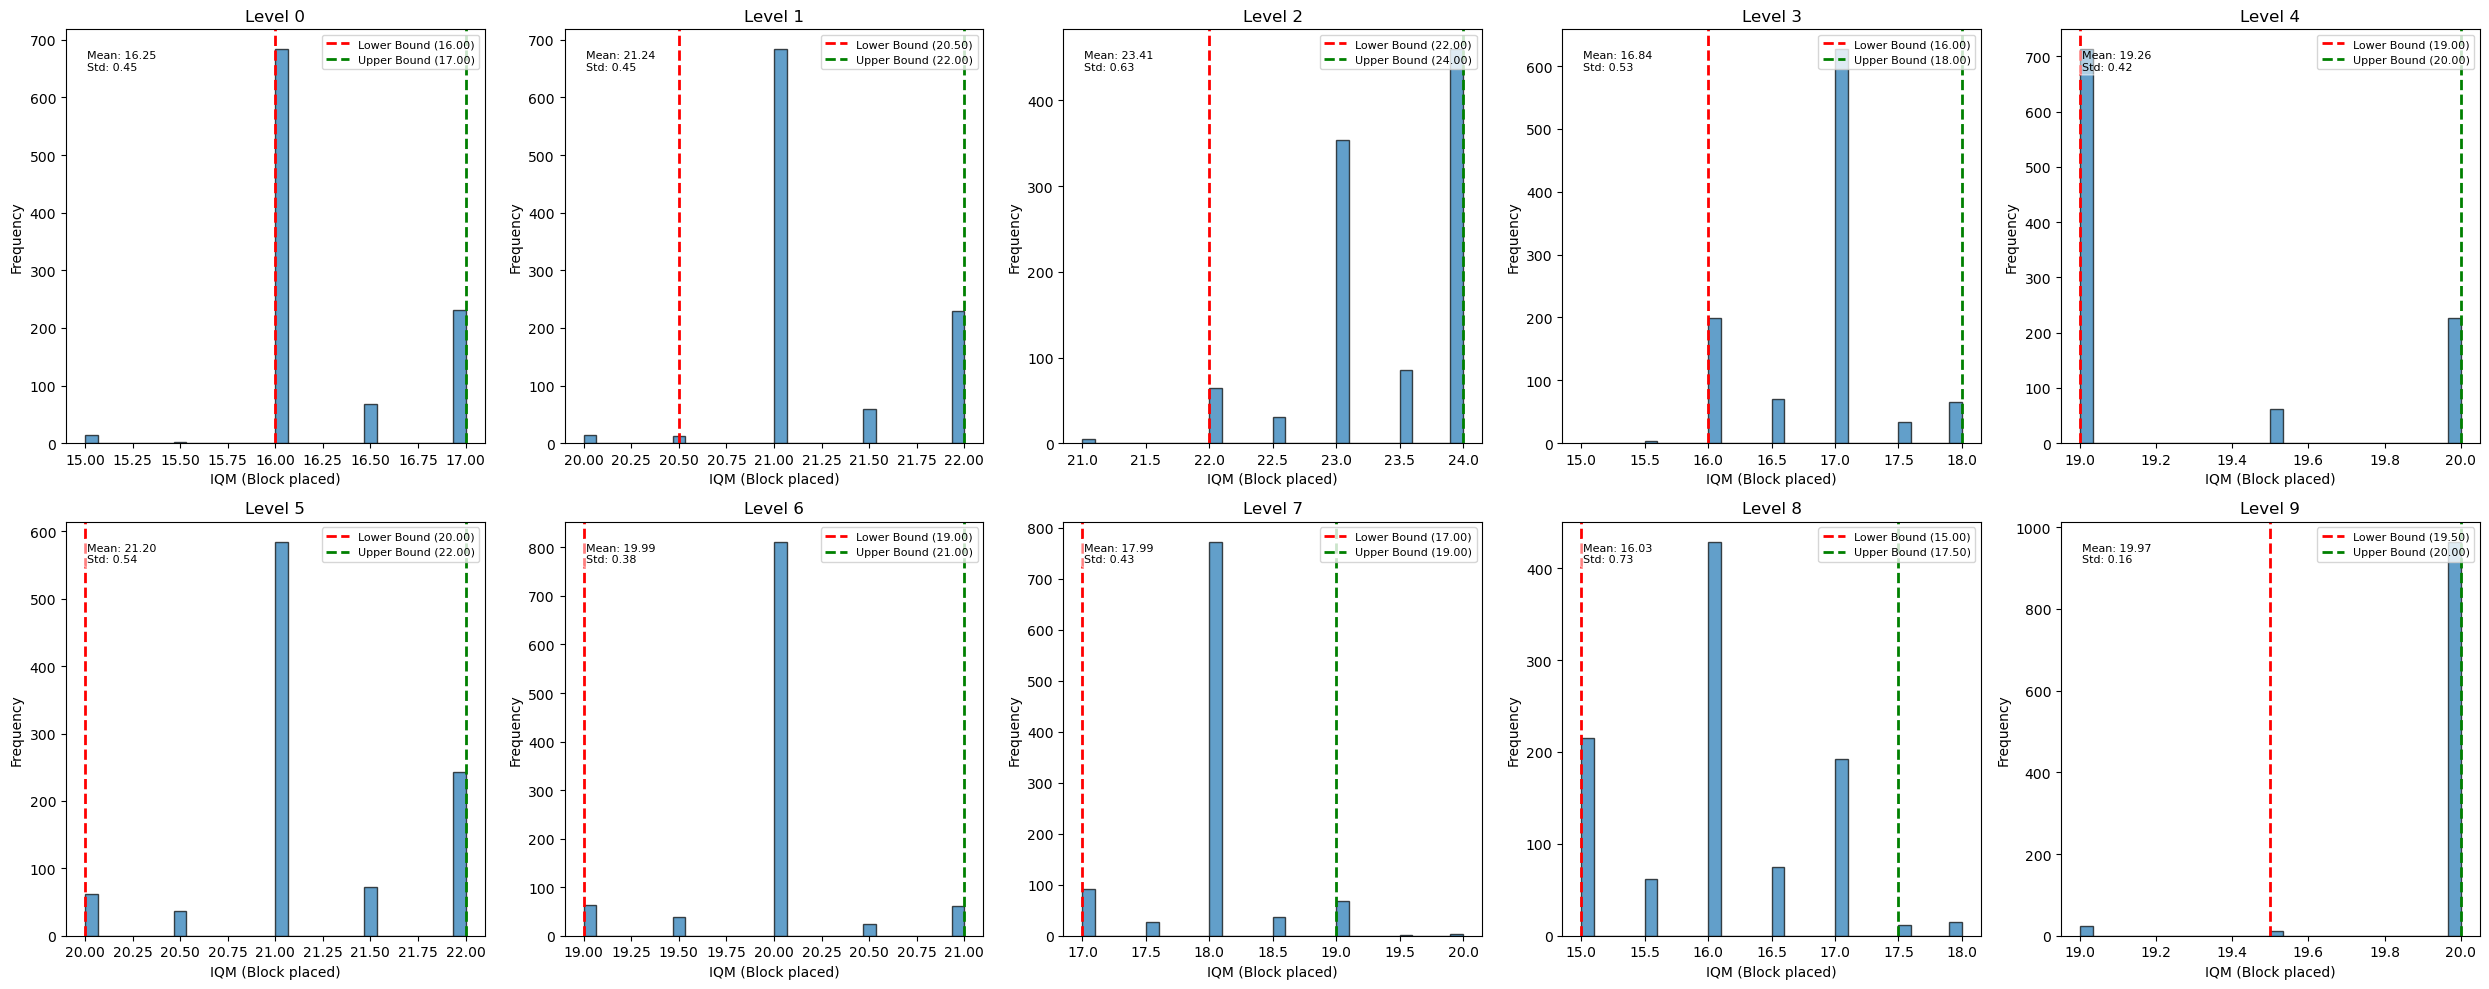

Level dengan konsistensi tertinggi: 9, dengan lebar distribusi 0.5
Level yang paling tidak konsisten: 8, dengan lebar distribusi 2.5


In [12]:
width = []
fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Membuat grid 2 baris dan 5 kolom
axes = axes.flatten()  # Membuat axes menjadi array 1D untuk akses mudah
for i in range(10):
    data = level[level["level"] == i+10]
    stats, lb, ub, mean, std = confidence_intervals(data, 100, "block_placed")

    # Membuat histogram distribusi data
    axes[i].hist(stats, bins=30, edgecolor='black', alpha=0.7)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper Bound ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
                 transform=axes[i].transAxes, fontsize=8, va='top', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=8)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_title(f'Level {i}')
    axes[i].set_xlabel('IQM (Block placed)')
    axes[i].set_ylabel('Frequency')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")
    width.append(ub-lb)

max_idx = width.index(max(width))
min_idx = width.index(min(width))
plt.tight_layout()  # Mengatur layout agar tidak overlap
plt.show()

print(f"Level dengan konsistensi tertinggi: {min_idx}, dengan lebar distribusi {width[min_idx]}")
print(f"Level yang paling tidak konsisten: {max_idx}, dengan lebar distribusi {width[max_idx]}", )

In [ ]:
width = []
fig, axes = plt.subplots(5, 4, figsize=(15, 20))  # Membuat grid 2 baris dan 5 kolom
axes = axes.flatten()  # Membuat axes menjadi array 1D untuk akses mudah
for i in range(10):
    data = level[level["level"] == i + 1]
    stats, lb, ub, mean, std = confidence_intervals(data, 100, "normalized_block_placed")

    # Membuat histogram distribusi data
    axes[i].hist(stats, bins=30, edgecolor='black', alpha=0.7)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper Bound ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
                 transform=axes[i].transAxes, fontsize=8, va='top', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=8)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_title(f'Level {i}')
    axes[i].set_xlabel('IQM (Normalized block placed)')
    axes[i].set_ylabel('Frequency')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")
    width.append(ub-lb)
    

max_idx = width.index(max(width))
min_idx = width.index(min(width))
plt.tight_layout()  # Mengatur layout agar tidak overlap
plt.show()

print(f"Level dengan konsistensi tertinggi: {min_idx}, dengan lebar distribusi {width[min_idx]}")
print(f"Level yang paling tidak konsisten: {max_idx}, dengan lebar distribusi {width[max_idx]}", )

In [ ]:
width = []
fig, axes = plt.subplots(5, 4, figsize=(15, 20))  # Membuat grid 2 baris dan 5 kolom
axes = axes.flatten()  # Membuat axes menjadi array 1D untuk akses mudah
for i in range(20):
    data = level[level["level"] == i]
    stats, lb, ub, mean, std = confidence_intervals(data, 100, "normalized_episode_time")

    # Membuat histogram distribusi data
    axes[i].hist(stats, bins=30, edgecolor='black', alpha=0.7)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper Bound ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
                 transform=axes[i].transAxes, fontsize=8, va='top', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=8)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_title(f'Level {i}')
    axes[i].set_xlabel('IQM (Normalized episode time)')
    axes[i].set_ylabel('Frequency')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")
    width.append(ub-lb)
    

max_idx = width.index(max(width))
min_idx = width.index(min(width))
plt.tight_layout()  # Mengatur layout agar tidak overlap
plt.show()

print(f"Level dengan konsistensi tertinggi: {min_idx}, dengan lebar distribusi {width[min_idx]}")
print(f"Level yang paling tidak konsisten: {max_idx}, dengan lebar distribusi {width[max_idx]}", )

In [ ]:
width = []
fig, axes = plt.subplots(5, 4, figsize=(15, 20))  # Membuat grid 2 baris dan 5 kolom
axes = axes.flatten()  # Membuat axes menjadi array 1D untuk akses mudah
for i in range(20):
    data = level[level["level"] == i]
    stats, lb, ub, mean, std = confidence_intervals(data, 100, "normalized_episode_length")

    # Membuat histogram distribusi data
    axes[i].hist(stats, bins=30, edgecolor='black', alpha=0.7)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower Bound ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper Bound ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
                 transform=axes[i].transAxes, fontsize=8, va='top', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=8)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_title(f'Level {i}')
    axes[i].set_xlabel('IQM (Normalized episode length)')
    axes[i].set_ylabel('Frequency')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")
    width.append(ub-lb)
    

max_idx = width.index(max(width))
min_idx = width.index(min(width))
plt.tight_layout()  # Mengatur layout agar tidak overlap
plt.show()

print(f"Level dengan konsistensi tertinggi: {min_idx}, dengan lebar distribusi {width[min_idx]}")
print(f"Level yang paling tidak konsisten: {max_idx}, dengan lebar distribusi {width[max_idx]}", )